# **KomuterPulse Model Development: LSTM for Ridership Prediction**

This notebook focuses on developing machine learning models for our KomuterPulse project, with special emphasis on LSTM networks for ridership prediction. The model will leverage the temporal patterns in our KTM Komuter transit data to forecast hourly ridership between station pairs.

## **Objectives**

1. Load and prepare the feature-engineered data
2. Transform the data for time series modeling (sequence creation)
3. Build and train LSTM models of various architectures
4. Compare model performance and select the best model
5. Save the trained model for later use

Let's start by importing the necessary libraries and loading our preprocessed data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from pathlib import Path
from datetime import datetime
import time

# For data preprocessing and scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model # type: ignore
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization, Input, Bidirectional, GRU # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

# For visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
sns.set_context("notebook", font_scale=1.2)

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 1000)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## **Data Loading and Preparation**

First, let's load the preprocessed and feature-engineered data along with the feature subsets identified in the feature engineering notebook.

In [3]:
# Define paths
DATA_DIR = Path('../data/processed')
train_path = DATA_DIR / 'komuter_train.csv'
test_path = DATA_DIR / 'komuter_test.csv'
feature_subsets_path = DATA_DIR / 'feature_subsets.pkl'

# Load data
try:
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    print(f"Training data loaded: {train_df.shape}")
    print(f"Testing data loaded: {test_df.shape}")
    
    # Load feature subsets
    with open(feature_subsets_path, 'rb') as f:
        feature_subsets = pickle.load(f)
    print("Feature subsets loaded successfully.")
    
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please run the preprocessing and feature engineering notebooks first.")

Training data loaded: (537642, 55)
Testing data loaded: (132957, 55)
Feature subsets loaded successfully.


In [4]:
# Display the available feature subsets and their sizes
for subset_name, features in feature_subsets.items():
    if isinstance(features, list):
        print(f"{subset_name}: {len(features)} features")
    else:
        print(f"{subset_name}: {features}")

# We'll use the consensus features identified from our feature engineering notebook
selected_features = feature_subsets['consensus_features']
print(f"\nSelected features for LSTM model ({len(selected_features)} features):")
print(selected_features)

all_features: 53 features
consensus_features: 18 features
rf_top_features: 15 features
xgb_top_features: 15 features
selectkbest_features: 20 features
pca_n_components: 19

Selected features for LSTM model (18 features):
['avg_ridership', 'max_ridership', 'ridership_diff_1d', 'ridership_diff_1h', 'ridership_diff_1w', 'ridership_diff_2h', 'ridership_pct_change_1d', 'ridership_pct_change_1w', 'rolling_max_12h', 'rolling_max_24h', 'rolling_max_3h', 'rolling_max_6h', 'rolling_mean_3h', 'rolling_mean_6h', 'rolling_min_3h', 'rolling_std_3h', 'rolling_std_6h', 'total_ridership_lag_2h']


## **LSTM Data Preparation**

LSTMs require data to be formatted as sequences. We need to transform our time series data into sequences where we use past `n_steps` observations to predict the next ridership value.

First, let's explore our data structure to understand how to create these sequences properly.

In [5]:
# Check the first few rows of the training data
train_df.head()

,route,date,hour,total_ridership,avg_ridership,max_ridership,day_of_week,is_weekend,origin,destination,origin_popularity,destination_popularity,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,total_ridership_lag_1h,total_ridership_lag_2h,total_ridership_lag_3h,total_ridership_lag_6h,total_ridership_lag_12h,total_ridership_lag_24h,total_ridership_lag_1w,rolling_mean_3h,rolling_std_3h,rolling_max_3h,rolling_min_3h,rolling_mean_6h,rolling_std_6h,rolling_max_6h,rolling_min_6h,rolling_mean_12h,rolling_std_12h,rolling_max_12h,rolling_min_12h,rolling_mean_24h,rolling_std_24h,rolling_max_24h,rolling_min_24h,rolling_dow_mean,ridership_diff_1h,ridership_diff_2h,ridership_pct_change_1h,ridership_diff_1d,ridership_pct_change_1d,ridership_diff_1w,ridership_pct_change_1w,hour_of_day,is_rush_hour,is_peak_morning,is_peak_evening,is_business_hours,is_night_hours,is_statistical_outlier,is_route_outlier
0,Abdullah Hukum → Abdullah Hukum,2025-01-03,22,2,2.0,2,4,False,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,-0.500000,0.866025,-0.433884,-0.900969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,2.947211,2.0,2.0,2.000000,3.723052,2.0,2.0,2.000000,4.406935,2.0,2.0,2.000000,4.704380,2.0,2.0,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,False,False,False,False,True,False,False
1,Abdullah Hukum → Abdullah Hukum,2025-01-05,14,1,1.0,1,6,True,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,-0.500000,-0.866025,-0.781831,0.623490,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.500000,0.707107,2.0,1.0,1.500000,0.707107,2.0,1.0,1.500000,0.707107,2.0,1.0,1.500000,0.707107,2.0,1.0,1.500000,-1.0,0.0,-0.5,0.0,0.0,0.0,0.0,14,False,False,False,False,False,False,False
2,Abdullah Hukum → Abdullah Hukum,2025-01-06,19,2,2.0,2,0,False,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,-0.965926,0.258819,0.000000,1.000000,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.666667,0.577350,2.0,1.0,1.666667,0.577350,2.0,1.0,1.666667,0.577350,2.0,1.0,1.666667,0.577350,2.0,1.0,1.666667,1.0,0.0,1.0,0.0,0.0,0.0,0.0,19,True,False,True,False,False,False,False
3,Abdullah Hukum → Abdullah Hukum,2025-01-07,16,1,1.0,1,1,False,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,-0.866025,-0.500000,0.781831,0.623490,2.0,1.0,2.0,0.0,0.0,0.0,0.0,1.333333,0.577350,2.0,1.0,1.500000,0.577350,2.0,1.0,1.500000,0.577350,2.0,1.0,1.500000,0.577350,2.0,1.0,1.500000,-1.0,0.0,-0.5,0.0,0.0,0.0,0.0,16,False,False,False,True,False,False,False
4,Abdullah Hukum → Abdullah Hukum,2025-01-07,19,1,1.0,1,1,False,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,-0.965926,0.258819,0.781831,0.623490,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.333333,0.577350,2.0,1.0,1.400000,0.547723,2.0,1.0,1.400000,0.547723,2.0,1.0,1.400000,0.547723,2.0,1.0,1.400000,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,19,True,False,True,False,False,False,False


In [6]:
# Define target variable
target_col = 'total_ridership'

# Check if we have any missing values
print(f"Missing values in training data: {train_df.isnull().sum().sum()}")
print(f"Missing values in test data: {test_df.isnull().sum().sum()}")

# Create a combined DataFrame for processing
# We'll use this for normalization, then split back into train/test
combined_df = pd.concat([train_df, test_df])

# Sort the data by route, date, and hour to ensure proper sequence
combined_df['date'] = pd.to_datetime(combined_df['date'])
combined_df = combined_df.sort_values(['route', 'date', 'hour']).reset_index(drop=True)

# Display basic statistics
print(f"Total number of routes: {combined_df['route'].nunique()}")
print(f"Date range: {combined_df['date'].min()} to {combined_df['date'].max()}")

# Create a unique identifier for each route
combined_df['route_id'] = combined_df['route'].astype('category').cat.codes
route_mapping = dict(zip(combined_df['route'].unique(), combined_df['route_id'].unique()))

# Show sample of route mapping
print(f"\nSample of route mapping (first 5):")
for i, (route, route_id) in enumerate(route_mapping.items()):
    print(f"{route}: {route_id}")
    if i >= 4:  # Show only first 5 routes
        break

Missing values in training data: 0
Missing values in test data: 0
Total number of routes: 3260
Date range: 2025-01-01 00:00:00 to 2025-04-22 00:00:00

Sample of route mapping (first 5):
Abdullah Hukum → Abdullah Hukum: 0
Abdullah Hukum → Angkasapuri: 1
Abdullah Hukum → Bandar Tasek Selatan: 2
Abdullah Hukum → Bangi: 3
Abdullah Hukum → Bank Negara: 4


### **Feature Selection and Normalization**

Let's prepare our selected features and normalize them for the LSTM model.

In [7]:
# Filter the data to include only the selected features and the target
features_to_use = selected_features.copy()

# Ensure all selected features exist in the dataset
features_to_use = [f for f in features_to_use if f in combined_df.columns]
print(f"Using {len(features_to_use)} features:")
print(features_to_use)

# Create input data (X) and target data (y)
X = combined_df[features_to_use].values
y = combined_df[target_col].values

# Normalize the input features using Min-Max scaling (important for LSTM)
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Normalize the target variable separately
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Create a DataFrame with scaled values for easier manipulation
scaled_df = pd.DataFrame(X_scaled, columns=features_to_use)
scaled_df[target_col] = y_scaled
scaled_df['route_id'] = combined_df['route_id'].values
scaled_df['date'] = combined_df['date'].values
scaled_df['hour'] = combined_df['hour'].values

# Display the scaled data
scaled_df.head()

Using 18 features:
['avg_ridership', 'max_ridership', 'ridership_diff_1d', 'ridership_diff_1h', 'ridership_diff_1w', 'ridership_diff_2h', 'ridership_pct_change_1d', 'ridership_pct_change_1w', 'rolling_max_12h', 'rolling_max_24h', 'rolling_max_3h', 'rolling_max_6h', 'rolling_mean_3h', 'rolling_mean_6h', 'rolling_min_3h', 'rolling_std_3h', 'rolling_std_6h', 'total_ridership_lag_2h']


,avg_ridership,max_ridership,ridership_diff_1d,ridership_diff_1h,ridership_diff_1w,ridership_diff_2h,ridership_pct_change_1d,ridership_pct_change_1w,rolling_max_12h,rolling_max_24h,rolling_max_3h,rolling_max_6h,rolling_mean_3h,rolling_mean_6h,rolling_min_3h,rolling_std_3h,rolling_std_6h,total_ridership_lag_2h,total_ridership,route_id,date,hour
0,0.001406,0.001406,0.534326,0.582677,0.524308,0.601240,0.002923,0.002928,0.001406,0.001406,0.001406,0.001406,0.001488,0.001565,0.001656,0.010006,0.014443,0.000000,0.001406,0,2025-01-03,22
1,0.000000,0.000000,0.534326,0.581102,0.524308,0.601240,0.002923,0.002928,0.001406,0.001406,0.001406,0.001406,0.000744,0.000782,0.000000,0.002401,0.002743,0.000000,0.000000,0,2025-01-05,14
2,0.001406,0.001406,0.534326,0.584252,0.524308,0.601240,0.002923,0.002928,0.001406,0.001406,0.001406,0.001406,0.000992,0.001043,0.000000,0.001960,0.002240,0.002809,0.001406,0,2025-01-06,19
3,0.000000,0.000000,0.534326,0.581102,0.524308,0.601240,0.002923,0.002928,0.001406,0.001406,0.001406,0.001406,0.000496,0.000782,0.000000,0.001960,0.002240,0.001404,0.000000,0,2025-01-07,16
4,0.000000,0.000000,0.534326,0.582677,0.524308,0.600207,0.002923,0.002928,0.001406,0.001406,0.001406,0.001406,0.000496,0.000626,0.000000,0.001960,0.002125,0.002809,0.000000,0,2025-01-07,19


### **Creating Sequences for LSTM**

For time series prediction with LSTM, we need to create sequences of past observations to predict future values. We'll create sequences for each route separately to maintain the temporal structure.

In [8]:
def create_sequences(data, route_ids, n_steps):
    """Create sequences for LSTM from the data.
    
    Args:
        data: The scaled data DataFrame
        route_ids: List of unique route IDs
        n_steps: Number of time steps to use for the sequence
        
    Returns:
        X_seq: Sequences for input features
        y_seq: Target values for each sequence
        metadata: Additional information for each sequence (route_id, date, hour)
    """
    X_seq, y_seq = [], []
    metadata = []  # Store route_id, date, hour for each sequence
    
    for route_id in route_ids:
        # Get data for this specific route
        route_data = data[data['route_id'] == route_id].sort_values('date')
        
        if len(route_data) <= n_steps:
            continue  # Skip routes with insufficient data
            
        # Extract feature columns (excluding metadata and target)
        feature_cols = [col for col in route_data.columns if col not in 
                        [target_col, 'route_id', 'date', 'hour']]
        
        # Create sequences for this route
        for i in range(len(route_data) - n_steps):
            # Get input sequence
            sequence = route_data.iloc[i:i+n_steps][feature_cols].values
            X_seq.append(sequence)
            
            # Get target (next value after the sequence)
            target = route_data.iloc[i+n_steps][target_col]
            y_seq.append(target)
            
            # Store metadata
            meta = {
                'route_id': route_id,
                'date': route_data.iloc[i+n_steps]['date'],
                'hour': route_data.iloc[i+n_steps]['hour']
            }
            metadata.append(meta)
    
    return np.array(X_seq), np.array(y_seq), metadata

# Define the sequence length (number of past time steps to use)
n_steps = 24  # Use 24 hours of data to predict the next hour

# Get unique route IDs
unique_route_ids = scaled_df['route_id'].unique()

# Create sequences
print("Creating sequences for LSTM...")
X_sequences, y_sequences, metadata = create_sequences(scaled_df, unique_route_ids, n_steps)

print(f"Created {len(X_sequences)} sequences with shape: {X_sequences.shape}")

Creating sequences for LSTM...
Created 612070 sequences with shape: (612070, 24, 18)


In [9]:
# Split the data into training and validation sets
# We'll use a custom split that preserves the temporal order

# Determine the split point
train_size = int(len(X_sequences) * 0.8)  # 80% for training

# Split the sequences
X_train = X_sequences[:train_size]
y_train = y_sequences[:train_size]
X_val = X_sequences[train_size:]
y_val = y_sequences[train_size:]

# Also split the metadata
train_metadata = metadata[:train_size]
val_metadata = metadata[train_size:]

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

Training set shape: (489656, 24, 18)
Validation set shape: (122414, 24, 18)


## **LSTM Model Development**

Now that we have prepared our data in the appropriate sequence format, let's build and train the LSTM model for ridership prediction.

We'll implement several LSTM architectures, starting with a basic model and gradually increasing complexity.

In [10]:
def build_basic_lstm_model(input_shape):
    """Build a basic LSTM model."""
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_stacked_lstm_model(input_shape):
    """Build a stacked LSTM model."""
    model = Sequential([
        LSTM(100, activation='relu', input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(50, activation='relu', return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_bidirectional_lstm_model(input_shape):
    """Build a bidirectional LSTM model."""
    model = Sequential([
        Bidirectional(LSTM(100, activation='relu', return_sequences=True), input_shape=input_shape),
        Dropout(0.2),
        Bidirectional(LSTM(50, activation='relu', return_sequences=False)),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_advanced_lstm_model(input_shape):
    """Build an advanced LSTM model with more sophisticated architecture."""
    inputs = Input(shape=input_shape)
    
    # First LSTM layer with batch normalization
    x = LSTM(128, activation='relu', return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Second LSTM layer
    x = LSTM(64, activation='relu', return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Third LSTM layer
    x = LSTM(32, activation='relu', return_sequences=False)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Dense layers
    x = Dense(16, activation='relu')(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    
    return model

# Set up input shape based on our sequence data
input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
print(f"Input shape for LSTM: {input_shape}")

Input shape for LSTM: (24, 18)


### **Model Training with Early Stopping**

We'll train our models with early stopping to prevent overfitting and reduce training time.

In [11]:
# Set up callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

# Create a checkpoint to save the best model
checkpoint_filepath = '../models/lstm_model_best.h5'
os.makedirs('../models', exist_ok=True)
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

### **Training the Basic LSTM Model**

Let's start with the basic LSTM model and evaluate its performance.

In [12]:
# Build and train the basic LSTM model
basic_model = build_basic_lstm_model(input_shape)
print("Basic LSTM Model Summary:")
basic_model.summary()

# Train the model
print("\nTraining Basic LSTM Model...")
start_time = time.time()

basic_history = basic_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

Basic LSTM Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                13800     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 13851 (54.11 KB)
Trainable params: 13851 (54.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Training Basic LSTM Model...
Epoch 1/50
15302/15302 [==============================] - ETA: 0s - loss: 1.4548e-04 - mae: 0.0052
Epoch 1: val_loss improved from inf to 0.00009, saving model to ../models\lstm_model_best.h5
15302/15302 [=======================

In [13]:
# Evaluate the model
def evaluate_model(model, X_test, y_test, scaler_y):
    """Evaluate the model and calculate performance metrics."""
    # Get predictions
    y_pred_scaled = model.predict(X_test)
    
    # Inverse transform to get actual ridership values
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_actual = scaler_y.inverse_transform(y_pred_scaled).flatten()
    
    # Calculate metrics
    mse = mean_squared_error(y_test_actual, y_pred_actual)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    r2 = r2_score(y_test_actual, y_pred_actual)
    
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }
    
    print("Model Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
        
    return y_test_actual, y_pred_actual, metrics

# Evaluate the basic model
y_val_actual, y_val_pred_basic, basic_metrics = evaluate_model(basic_model, X_val, y_val, scaler_y)

3826/3826 [==============================] - 14s 3ms/step
Model Performance:
MSE: 39.8843
RMSE: 6.3154
MAE: 2.5751
R²: 0.5390


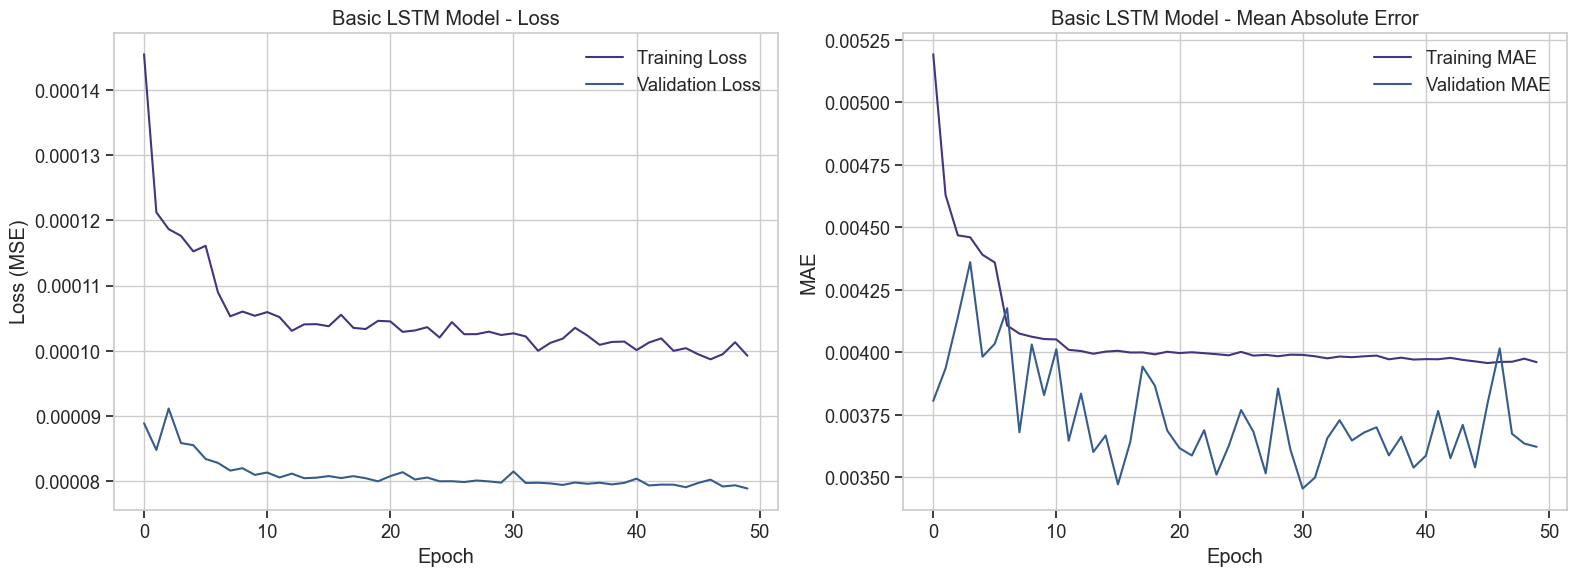

In [14]:
# Plot the model training history
def plot_training_history(history, title):
    """Plot the training and validation loss."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (MSE)')
    ax1.legend()
    ax1.grid(True)
    
    # Plot MAE
    ax2.plot(history.history['mae'], label='Training MAE')
    ax2.plot(history.history['val_mae'], label='Validation MAE')
    ax2.set_title(f'{title} - Mean Absolute Error')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot the training history of the basic model
plot_training_history(basic_history, 'Basic LSTM Model')

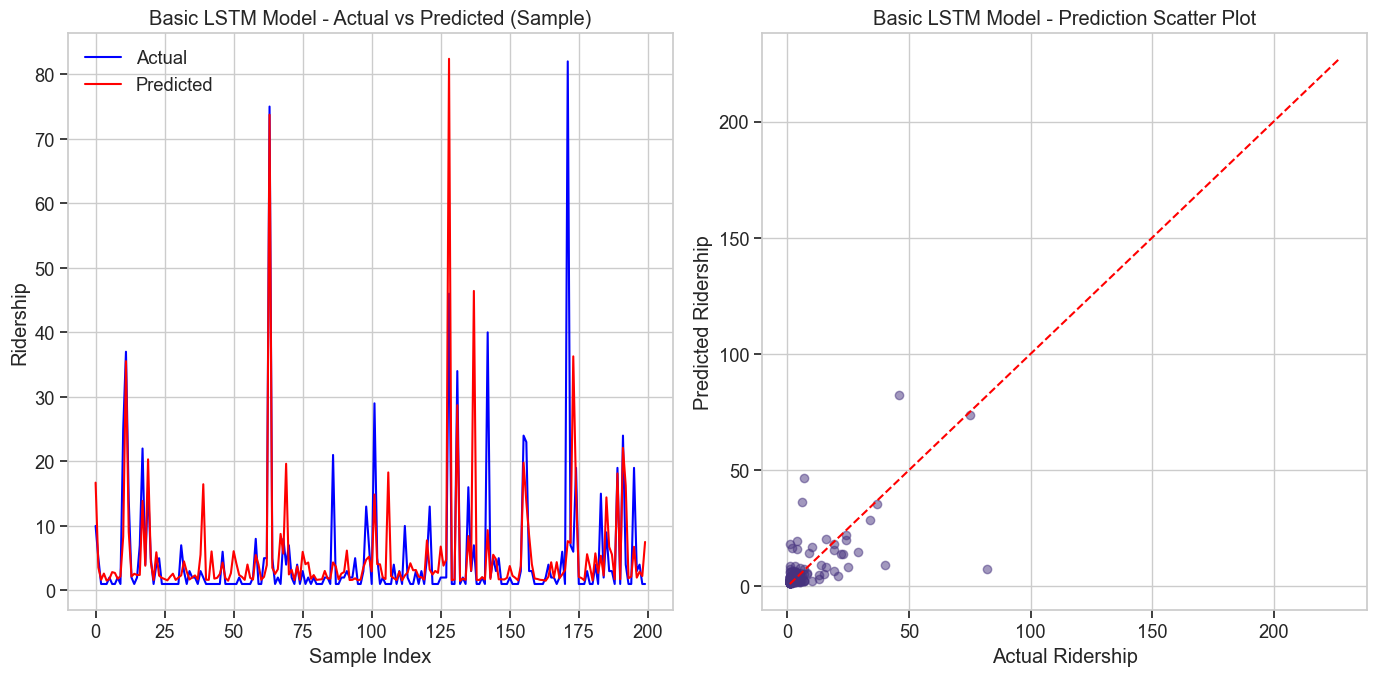

In [15]:
# Visualize predictions vs actual values
def plot_predictions(y_true, y_pred, title, n_samples=200):
    """Plot the actual vs predicted values."""
    # Sample a subset of data points to make the plot more readable
    if len(y_true) > n_samples:
        indices = np.random.choice(len(y_true), n_samples, replace=False)
        y_true_sample = y_true[indices]
        y_pred_sample = y_pred[indices]
    else:
        y_true_sample = y_true
        y_pred_sample = y_pred
    
    plt.figure(figsize=(14, 7))
    
    # Plot actual vs predicted
    plt.subplot(1, 2, 1)
    plt.plot(y_true_sample, color='blue', label='Actual')
    plt.plot(y_pred_sample, color='red', label='Predicted')
    plt.title(f'{title} - Actual vs Predicted (Sample)')
    plt.xlabel('Sample Index')
    plt.ylabel('Ridership')
    plt.legend()
    plt.grid(True)
    
    # Scatter plot
    plt.subplot(1, 2, 2)
    plt.scatter(y_true_sample, y_pred_sample, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.title(f'{title} - Prediction Scatter Plot')
    plt.xlabel('Actual Ridership')
    plt.ylabel('Predicted Ridership')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot predictions of the basic model
plot_predictions(y_val_actual, y_val_pred_basic, 'Basic LSTM Model')

### **Training the Stacked LSTM Model**

Let's try a more complex stacked LSTM model to see if it improves performance.

Stacked LSTM Model Summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 24, 100)           47600     
                                                                 
 dropout_1 (Dropout)         (None, 24, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 25)                1275      
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 79101 (308.9

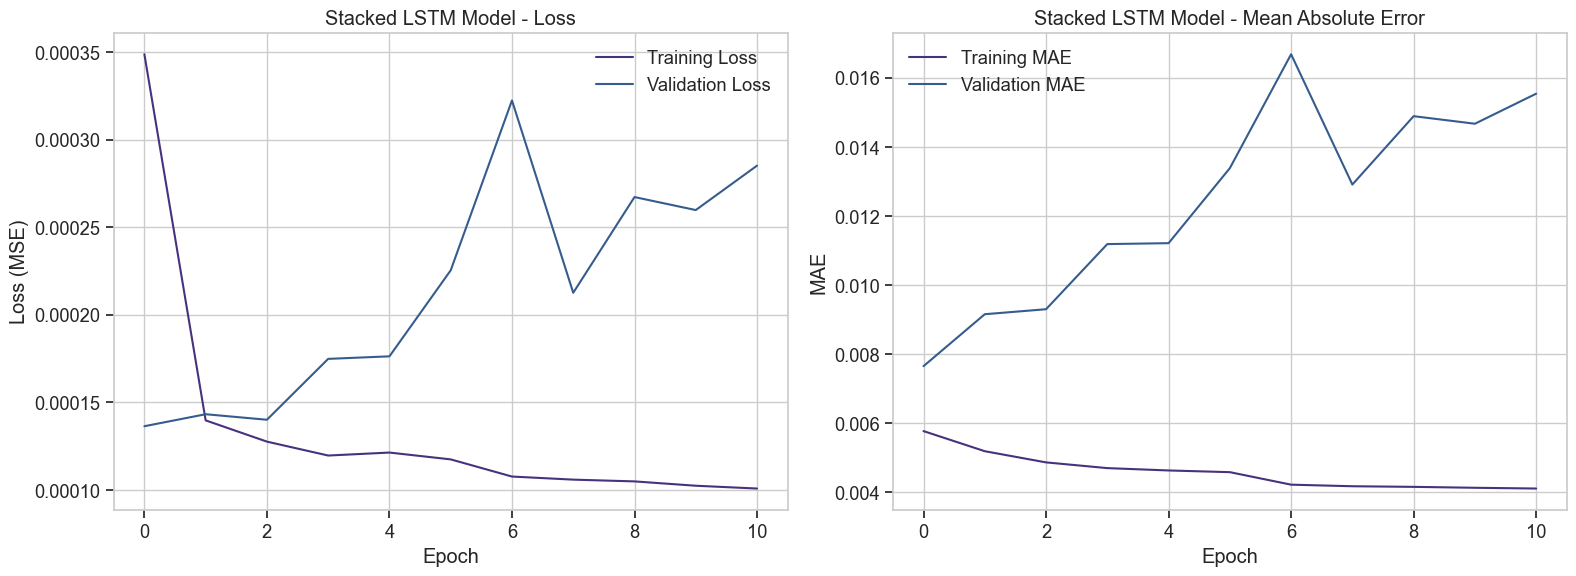

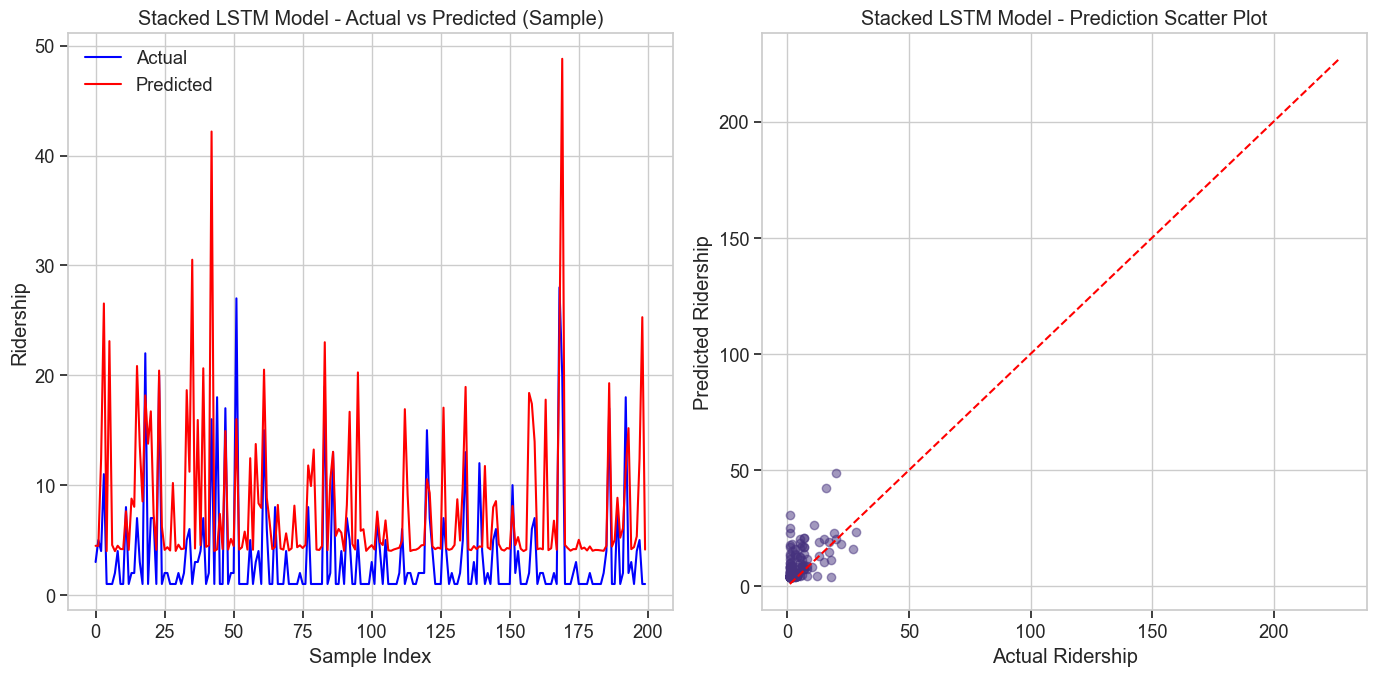

In [16]:
# Build and train the stacked LSTM model
stacked_model = build_stacked_lstm_model(input_shape)
print("Stacked LSTM Model Summary:")
stacked_model.summary()

# Train the model
print("\nTraining Stacked LSTM Model...")
start_time = time.time()

stacked_history = stacked_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Evaluate the stacked model
y_val_actual, y_val_pred_stacked, stacked_metrics = evaluate_model(stacked_model, X_val, y_val, scaler_y)

# Plot the training history and predictions
plot_training_history(stacked_history, 'Stacked LSTM Model')
plot_predictions(y_val_actual, y_val_pred_stacked, 'Stacked LSTM Model')

### **Training the Bidirectional LSTM Model**

Next, let's try a bidirectional LSTM model which can learn from both past and future states.

Bidirectional LSTM Model Summary:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 24, 200)           95200     
 al)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 24, 200)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 100)               100400    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 25)                2525      
                                                                 
 dense_4 (Dense)    

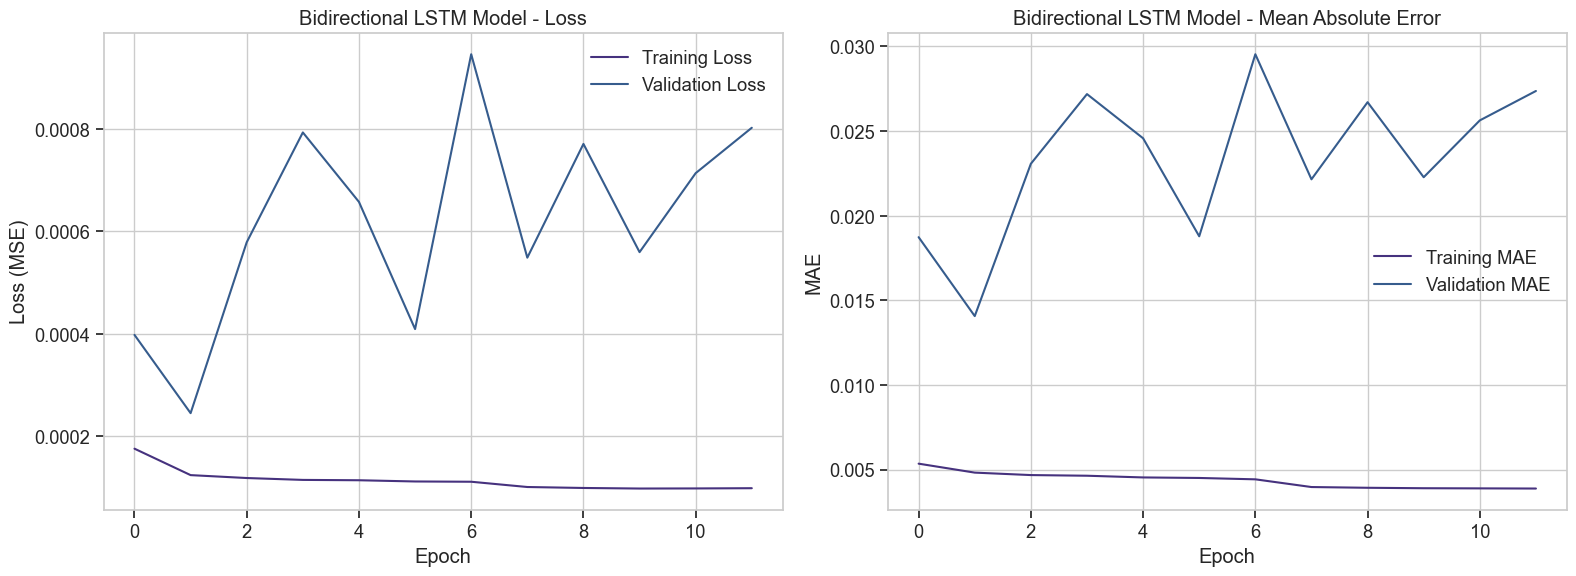

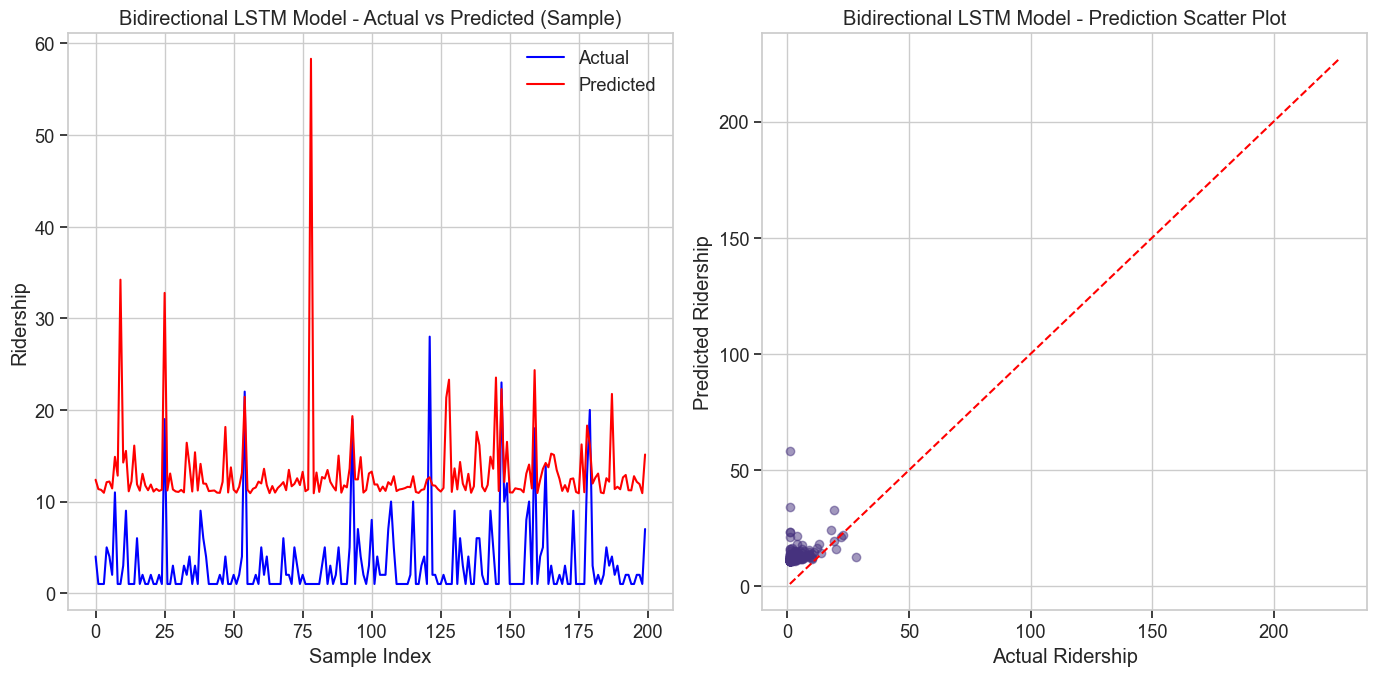

In [17]:
# Build and train the bidirectional LSTM model
bidirectional_model = build_bidirectional_lstm_model(input_shape)
print("Bidirectional LSTM Model Summary:")
bidirectional_model.summary()

# Train the model
print("\nTraining Bidirectional LSTM Model...")
start_time = time.time()

bidirectional_history = bidirectional_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Evaluate the bidirectional model
y_val_actual, y_val_pred_bidirectional, bidirectional_metrics = evaluate_model(
    bidirectional_model, X_val, y_val, scaler_y
)

# Plot the training history and predictions
plot_training_history(bidirectional_history, 'Bidirectional LSTM Model')
plot_predictions(y_val_actual, y_val_pred_bidirectional, 'Bidirectional LSTM Model')

### **Training the Advanced LSTM Model**

Finally, let's try our most advanced LSTM model with batch normalization and additional layers.

Advanced LSTM Model Summary:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 18)]          0         
                                                                 
 lstm_5 (LSTM)               (None, 24, 128)           75264     
                                                                 
 batch_normalization (Batch  (None, 24, 128)           512       
 Normalization)                                                  
                                                                 
 dropout_5 (Dropout)         (None, 24, 128)           0         
                                                                 
 lstm_6 (LSTM)               (None, 24, 64)            49408     
                                                                 
 batch_normalization_1 (Bat  (None, 24, 64)            256       
 chNormalization)               

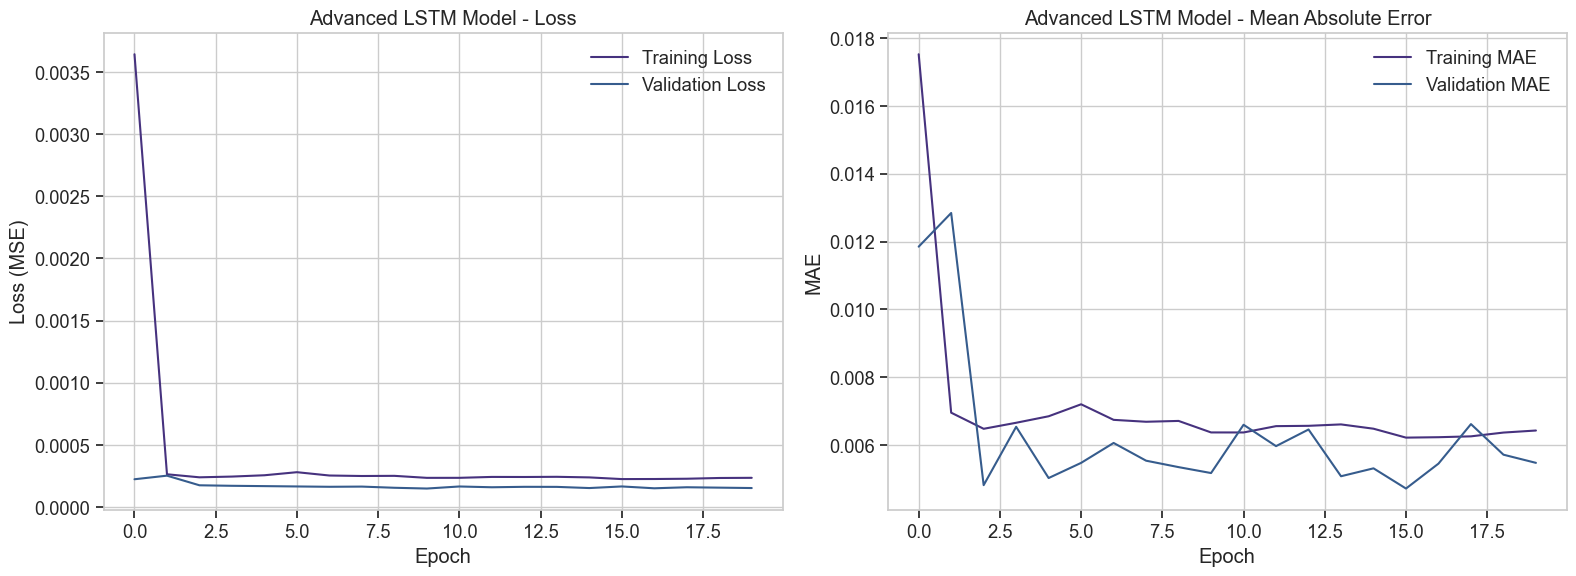

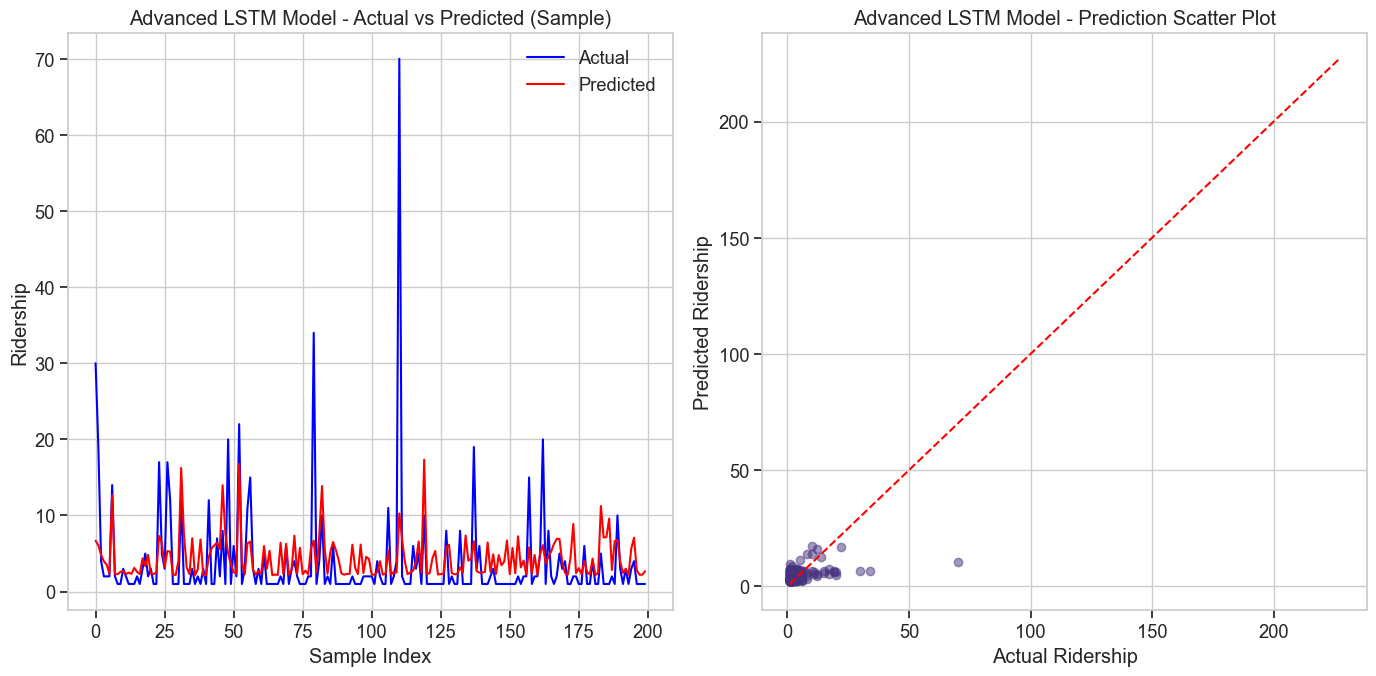

In [18]:
# Build and train the advanced LSTM model
advanced_model = build_advanced_lstm_model(input_shape)
print("Advanced LSTM Model Summary:")
advanced_model.summary()

# Train the model
print("\nTraining Advanced LSTM Model...")
start_time = time.time()

advanced_history = advanced_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Evaluate the advanced model
y_val_actual, y_val_pred_advanced, advanced_metrics = evaluate_model(
    advanced_model, X_val, y_val, scaler_y
)

# Plot the training history and predictions
plot_training_history(advanced_history, 'Advanced LSTM Model')
plot_predictions(y_val_actual, y_val_pred_advanced, 'Advanced LSTM Model')

## **Model Comparison**

Let's compare the performance of all the LSTM models we've trained.

Model Performance Comparison:
      Basic LSTM  Stacked LSTM  Bidirectional LSTM  Advanced LSTM
MSE    39.884275     68.891230          124.052998      74.938254
RMSE    6.315400      8.300074           11.137908       8.656688
MAE     2.575062      5.439086           10.003885       3.682773
R²      0.538987      0.203702           -0.433900       0.133806


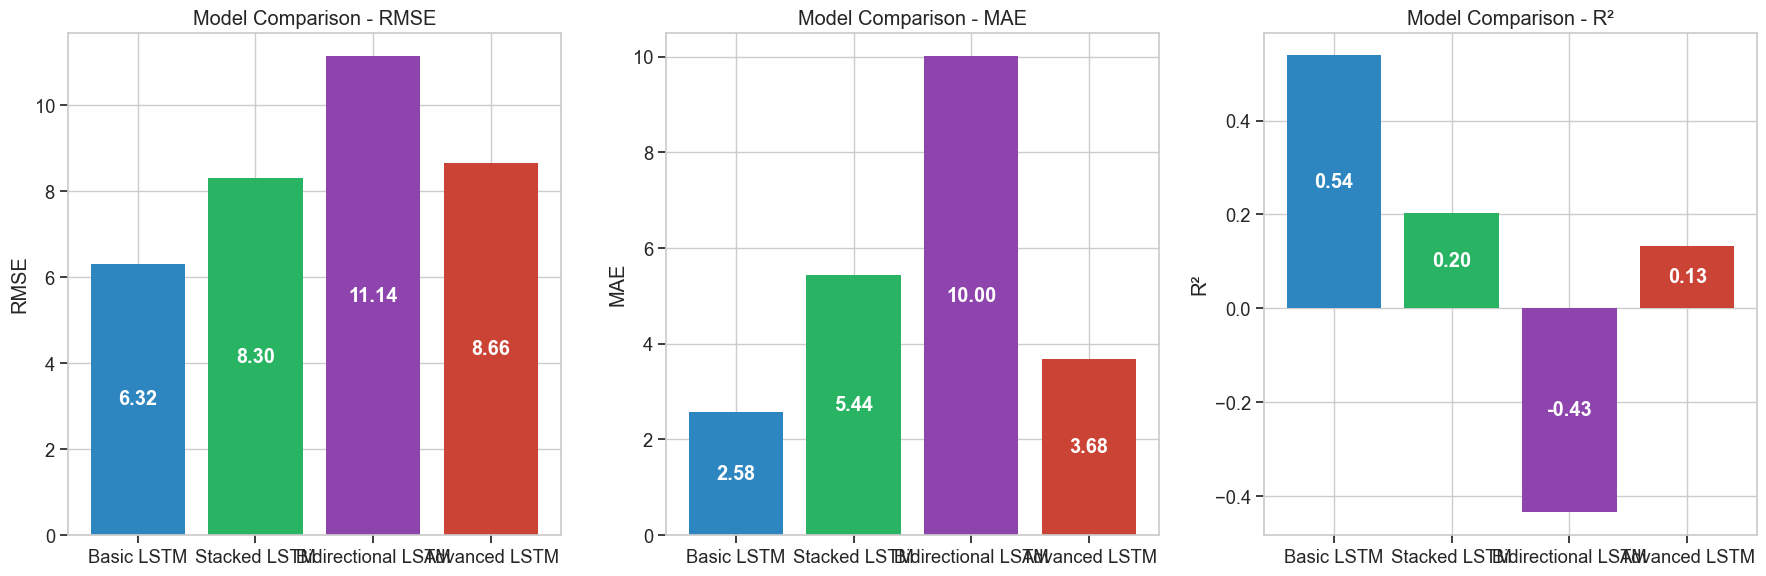

In [19]:
# Combine all metrics for comparison
models_metrics = {
    'Basic LSTM': basic_metrics,
    'Stacked LSTM': stacked_metrics,
    'Bidirectional LSTM': bidirectional_metrics,
    'Advanced LSTM': advanced_metrics
}

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    model_name: metrics for model_name, metrics in models_metrics.items()
})

# Display the comparison
print("Model Performance Comparison:")
print(comparison_df)

# Plot the comparison
metrics_to_plot = ['RMSE', 'MAE', 'R²']
fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(18, 6))

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    if metric == 'R²':
        # Higher is better for R²
        ax.bar(comparison_df.columns, comparison_df.loc[metric], color=['#2E86C1', '#28B463', '#8E44AD', '#CB4335'])
    else:
        # Lower is better for RMSE, MAE
        ax.bar(comparison_df.columns, comparison_df.loc[metric], color=['#CB4335', '#8E44AD', '#28B463', '#2E86C1'][::-1])
    
    ax.set_title(f'Model Comparison - {metric}')
    ax.set_ylabel(metric)
    for j, val in enumerate(comparison_df.loc[metric]):
        ax.text(j, val/2, f'{val:.2f}', ha='center', va='center', color='white', fontweight='bold')
    
plt.tight_layout()
plt.show()

## **Select the Best Model**

Based on the metrics, let's select the best model for our KomuterPulse ridership prediction.

In [20]:
# Find the best model based on RMSE (lower is better)
best_model_name = comparison_df.loc['RMSE'].idxmin()
best_rmse = comparison_df.loc['RMSE', best_model_name]

print(f"The best model based on RMSE is: {best_model_name} with RMSE = {best_rmse:.4f}")

# Assign the corresponding model object based on the best model name
model_objects = {
    'Basic LSTM': basic_model,
    'Stacked LSTM': stacked_model,
    'Bidirectional LSTM': bidirectional_model,
    'Advanced LSTM': advanced_model
}

best_model = model_objects[best_model_name]

# Alternatively, we can load the best model that was saved during training
# best_model = load_model(checkpoint_filepath)

The best model based on RMSE is: Basic LSTM with RMSE = 6.3154


## **Save the Final Model and Preprocessing Information**

Let's save our best model and the necessary preprocessing information for later use in the evaluation notebook.

In [21]:
# Create a directory to save models if it doesn't exist
model_dir = Path('../models')
model_dir.mkdir(exist_ok=True)

# Save the best model
best_model_path = model_dir / f"lstm_model_{best_model_name.replace(' ', '_').lower()}.h5"
best_model.save(str(best_model_path))
print(f"Best model saved to {best_model_path}")

# Save the scalers and other preprocessing information
preprocessing_info = {
    'scaler_X': scaler_X,
    'scaler_y': scaler_y,
    'features_used': features_to_use,
    'n_steps': n_steps,
    'target_col': target_col,
    'route_mapping': route_mapping,
    'model_metrics': models_metrics
}

preprocessing_path = model_dir / "lstm_preprocessing_info.pkl"
with open(preprocessing_path, 'wb') as f:
    pickle.dump(preprocessing_info, f)
print(f"Preprocessing information saved to {preprocessing_path}")

Best model saved to ..\models\lstm_model_basic_lstm.h5
Preprocessing information saved to ..\models\lstm_preprocessing_info.pkl


## **Hybrid Anomaly Detection & Actionable Recommendations**
This section implements a hybrid anomaly detection approach (LSTM residuals + Isolation Forest) and generates actionable recommendations for KTM Komuter operations, fully aligning with the project objectives in the README.md.

In [22]:
from sklearn.ensemble import IsolationForest

# Calculate residuals (errors) for the best model on validation set
val_predictions = best_model.predict(X_val)
val_predictions_actual = scaler_y.inverse_transform(val_predictions).flatten()
val_actual = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten()
residuals = val_actual - val_predictions_actual

# Statistical threshold for anomaly (e.g., 99th percentile of absolute residuals)
threshold = np.percentile(np.abs(residuals), 99)
anomaly_statistical = (np.abs(residuals) > threshold).astype(int)

# Isolation Forest for anomaly detection (hybrid approach)
iso_forest = IsolationForest(contamination=0.01, random_state=42)
residuals_reshape = residuals.reshape(-1, 1)
iso_labels = iso_forest.fit_predict(residuals_reshape)
# Isolation Forest: -1 = anomaly, 1 = normal
anomaly_isoforest = (iso_labels == -1).astype(int)

# Combine both methods (flag as anomaly if either method detects it)
anomaly_combined = np.maximum(anomaly_statistical, anomaly_isoforest)

# Add anomaly results to a DataFrame for actionable insights
anomaly_df = pd.DataFrame({
    'route_id': [meta['route_id'] for meta in val_metadata],
    'date': [meta['date'] for meta in val_metadata],
    'hour': [meta['hour'] for meta in val_metadata],
    'actual_ridership': val_actual,
    'predicted_ridership': val_predictions_actual,
    'residual': residuals,
    'anomaly_statistical': anomaly_statistical,
    'anomaly_isoforest': anomaly_isoforest,
    'anomaly_combined': anomaly_combined
})

# --- Actionable Recommendations ---
def generate_recommendations(anomaly_df, route_mapping):
    """Generate operational recommendations based on detected anomalies."""
    recommendations = []
    for _, row in anomaly_df[anomaly_df['anomaly_combined'] == 1].iterrows():
        route_name = [k for k, v in route_mapping.items() if v == row['route_id']][0]
        rec = {
            'route': route_name,
            'date': row['date'],
            'hour': row['hour'],
            'actual_ridership': row['actual_ridership'],
            'predicted_ridership': row['predicted_ridership'],
            'recommendation': f"Consider adding extra train(s) or adjusting schedule for {route_name} at {row['hour']}h on {row['date'].date()} due to anomalous ridership."
        }
        recommendations.append(rec)
    return pd.DataFrame(recommendations)

recommendations_df = generate_recommendations(anomaly_df, route_mapping)

print(f"\nNumber of actionable recommendations generated: {len(recommendations_df)}")
if len(recommendations_df) > 0:
    display(recommendations_df.head())
else:
    print("No anomalies detected in the validation set.")

# --- Save All Artifacts (Model, Scalers, Anomaly Model, Recommendations) ---
# Save updated preprocessing and anomaly detection info
preprocessing_info = {
    'scaler_X': scaler_X,
    'scaler_y': scaler_y,
    'features_used': features_to_use,
    'n_steps': n_steps,
    'target_col': target_col,
    'route_mapping': route_mapping,
    'model_metrics': models_metrics,
    'anomaly_threshold': threshold,
    'isolation_forest': iso_forest,
    'recommendations': recommendations_df,
}

preprocessing_path = model_dir / "lstm_preprocessing_info.pkl"
with open(preprocessing_path, 'wb') as f:
    pickle.dump(preprocessing_info, f)
print(f"Updated preprocessing and anomaly info saved to {preprocessing_path}")

3826/3826 [==============================] - 15s 4ms/step

Number of actionable recommendations generated: 1239


,route,date,hour,actual_ridership,predicted_ridership,recommendation
0,Serendah → KL Sentral,2025-01-08,7,39.0,5.363649,Consider adding extra train(s) or adjusting sc...
1,Serendah → KL Sentral,2025-01-08,8,43.0,13.922792,Consider adding extra train(s) or adjusting sc...
2,Serendah → KL Sentral,2025-01-13,8,36.0,3.225359,Consider adding extra train(s) or adjusting sc...
3,Serendah → KL Sentral,2025-01-16,7,41.0,3.537458,Consider adding extra train(s) or adjusting sc...
4,Serendah → KL Sentral,2025-01-16,8,44.0,7.413558,Consider adding extra train(s) or adjusting sc...


Updated preprocessing and anomaly info saved to ..\models\lstm_preprocessing_info.pkl


## **Feature Importance Analysis**

While traditional feature importance methods don't directly apply to LSTM models, we can use permutation importance to assess which features are most critical.

In [23]:
from sklearn.ensemble import IsolationForest

# Calculate residuals (errors) for the best model on validation set
val_predictions = best_model.predict(X_val)
val_predictions_actual = scaler_y.inverse_transform(val_predictions).flatten()
val_actual = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten()
residuals = val_actual - val_predictions_actual

# Statistical threshold for anomaly (e.g., 99th percentile of absolute residuals)
threshold = np.percentile(np.abs(residuals), 99)
anomaly_statistical = (np.abs(residuals) > threshold).astype(int)

# Isolation Forest for anomaly detection (hybrid approach)
iso_forest = IsolationForest(contamination=0.01, random_state=42)
residuals_reshape = residuals.reshape(-1, 1)
iso_labels = iso_forest.fit_predict(residuals_reshape)
# Isolation Forest: -1 = anomaly, 1 = normal
anomaly_isoforest = (iso_labels == -1).astype(int)

# Combine both methods (flag as anomaly if either method detects it)
anomaly_combined = np.maximum(anomaly_statistical, anomaly_isoforest)

# Add anomaly results to a DataFrame for actionable insights
anomaly_df = pd.DataFrame({
    'route_id': [meta['route_id'] for meta in val_metadata],
    'date': [meta['date'] for meta in val_metadata],
    'hour': [meta['hour'] for meta in val_metadata],
    'actual_ridership': val_actual,
    'predicted_ridership': val_predictions_actual,
    'residual': residuals,
    'anomaly_statistical': anomaly_statistical,
    'anomaly_isoforest': anomaly_isoforest,
    'anomaly_combined': anomaly_combined
})

# --- Actionable Recommendations ---
def generate_recommendations(anomaly_df, route_mapping):
    """Generate operational recommendations based on detected anomalies."""
    recommendations = []
    for _, row in anomaly_df[anomaly_df['anomaly_combined'] == 1].iterrows():
        route_name = [k for k, v in route_mapping.items() if v == row['route_id']][0]
        rec = {
            'route': route_name,
            'date': row['date'],
            'hour': row['hour'],
            'actual_ridership': row['actual_ridership'],
            'predicted_ridership': row['predicted_ridership'],
            'recommendation': f"Consider adding extra train(s) or adjusting schedule for {route_name} at {row['hour']}h on {row['date'].date()} due to anomalous ridership."
        }
        recommendations.append(rec)
    return pd.DataFrame(recommendations)

recommendations_df = generate_recommendations(anomaly_df, route_mapping)

print(f"\nNumber of actionable recommendations generated: {len(recommendations_df)}")
if len(recommendations_df) > 0:
    display(recommendations_df.head())
else:
    print("No anomalies detected in the validation set.")

# --- Save All Artifacts (Model, Scalers, Anomaly Model, Recommendations) ---
# Save updated preprocessing and anomaly detection info
preprocessing_info = {
    'scaler_X': scaler_X,
    'scaler_y': scaler_y,
    'features_used': features_to_use,
    'n_steps': n_steps,
    'target_col': target_col,
    'route_mapping': route_mapping,
    'model_metrics': models_metrics,
    'anomaly_threshold': threshold,
    'isolation_forest': iso_forest,
    'recommendations': recommendations_df,
}

preprocessing_path = model_dir / "lstm_preprocessing_info.pkl"
with open(preprocessing_path, 'wb') as f:
    pickle.dump(preprocessing_info, f)
print(f"Updated preprocessing and anomaly info saved to {preprocessing_path}")

3826/3826 [==============================] - 14s 4ms/step

Number of actionable recommendations generated: 1239


,route,date,hour,actual_ridership,predicted_ridership,recommendation
0,Serendah → KL Sentral,2025-01-08,7,39.0,5.363649,Consider adding extra train(s) or adjusting sc...
1,Serendah → KL Sentral,2025-01-08,8,43.0,13.922792,Consider adding extra train(s) or adjusting sc...
2,Serendah → KL Sentral,2025-01-13,8,36.0,3.225359,Consider adding extra train(s) or adjusting sc...
3,Serendah → KL Sentral,2025-01-16,7,41.0,3.537458,Consider adding extra train(s) or adjusting sc...
4,Serendah → KL Sentral,2025-01-16,8,44.0,7.413558,Consider adding extra train(s) or adjusting sc...


Updated preprocessing and anomaly info saved to ..\models\lstm_preprocessing_info.pkl


Calculating feature importance using permutation importance...
This may take some time...
32/32 [==============================] - 0s 5ms/step
Baseline MSE: 0.0000
32/32 [==============================] - 0s 4ms/step

Feature Importance:
                    Feature    Importance
17   total_ridership_lag_2h  7.487283e-07
13          rolling_mean_6h  5.514982e-07
3         ridership_diff_1h  3.853072e-07
12          rolling_mean_3h  2.223684e-07
8           rolling_max_12h  1.198388e-07
14           rolling_min_3h  1.105733e-07
10           rolling_max_3h  8.490037e-08
11           rolling_max_6h  7.476998e-08
5         ridership_diff_2h  7.108845e-08
16           rolling_std_6h  5.398176e-08
9           rolling_max_24h  3.973902e-08
7   ridership_pct_change_1w  6.965920e-09
2         ridership_diff_1d  5.192260e-09
6   ridership_pct_change_1d -8.860197e-10
4         ridership_diff_1w -2.773907e-09
15           rolling_std_3h -1.443361e-08
1             max_ridership -2.939503e-08
0     

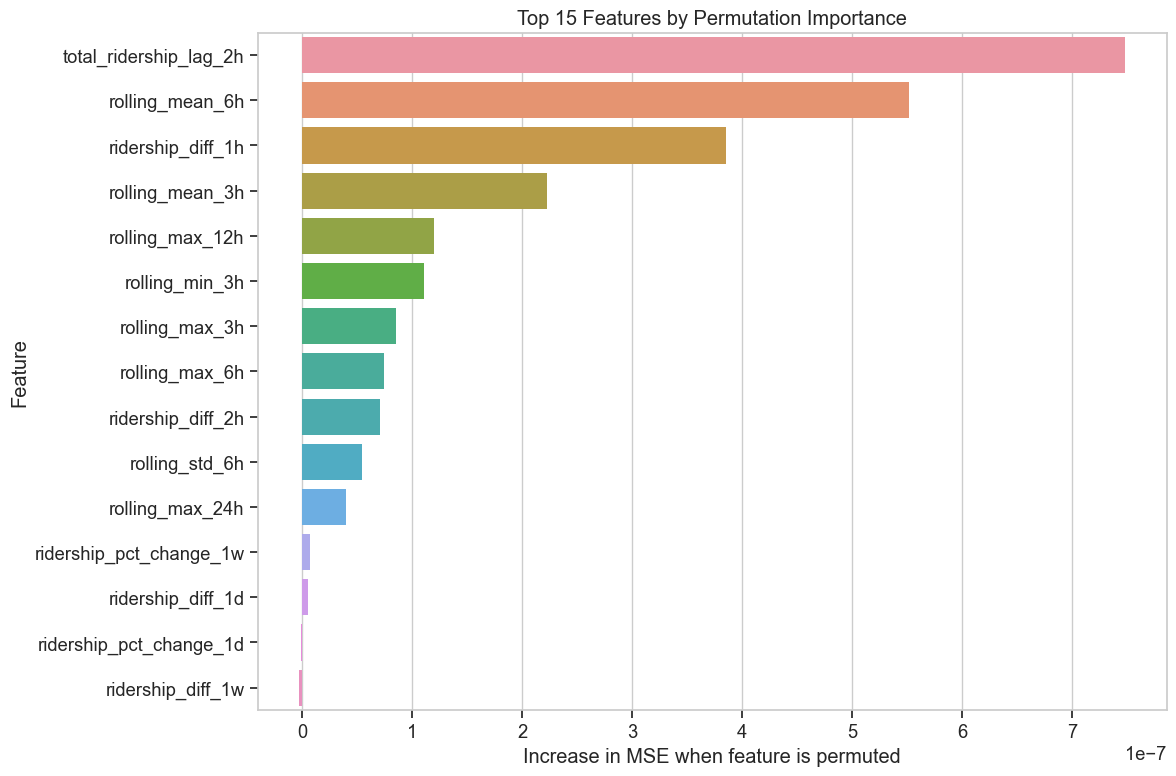

In [24]:
def permutation_importance_lstm(model, X, y, feature_names, n_repeats=5):
    """Calculate permutation importance for LSTM features."""
    # Baseline score without any perturbation
    baseline_score = mean_squared_error(y, model.predict(X))
    print(f"Baseline MSE: {baseline_score:.4f}")
    
    importance_scores = []
    
    # Loop through each feature index
    for i in range(X.shape[2]):  # For 3D input: (samples, timesteps, features)
        feature_importance = []
        
        for _ in range(n_repeats):
            # Create a copy of the input data
            X_permuted = X.copy()
            
            # Permute the values of the current feature across all timesteps
            for t in range(X.shape[1]):  # Loop through timesteps
                X_permuted[:, t, i] = np.random.permutation(X_permuted[:, t, i])
            
            # Calculate score with the permuted feature
            permuted_score = mean_squared_error(y, model.predict(X_permuted))
            
            # The importance is the increase in error
            feature_importance.append(permuted_score - baseline_score)
        
        # Average importance across repeats
        importance_scores.append(np.mean(feature_importance))
    
    # Create DataFrame with importance scores
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_scores
    })
    
    # Sort by importance (descending)
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    return importance_df

# Calculate feature importance
# Note: This can take a significant amount of time, so we'll use a smaller validation set
sample_size = min(1000, len(X_val))  # Limit for faster computation
X_val_sample = X_val[:sample_size]
y_val_sample = y_val[:sample_size]

print("Calculating feature importance using permutation importance...")
print("This may take some time...")

feature_importance = permutation_importance_lstm(
    best_model, X_val_sample, y_val_sample, features_to_use, n_repeats=3
)

print("\nFeature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Features by Permutation Importance')
plt.xlabel('Increase in MSE when feature is permuted')
plt.tight_layout()
plt.show()

## **Multi-Step Forecasting**

Let's also implement a function to perform multi-step forecasting, which is useful for predicting ridership several hours into the future.

1/1 [==============================] - 0s 28ms/step
Forecasted values for the next 12 hours:
[2.7436109 3.2028024 3.1417046 3.1941488 3.1594262 3.1610625 3.1097777
 3.102776  3.0947819 3.091728  3.0946367 3.1117573]


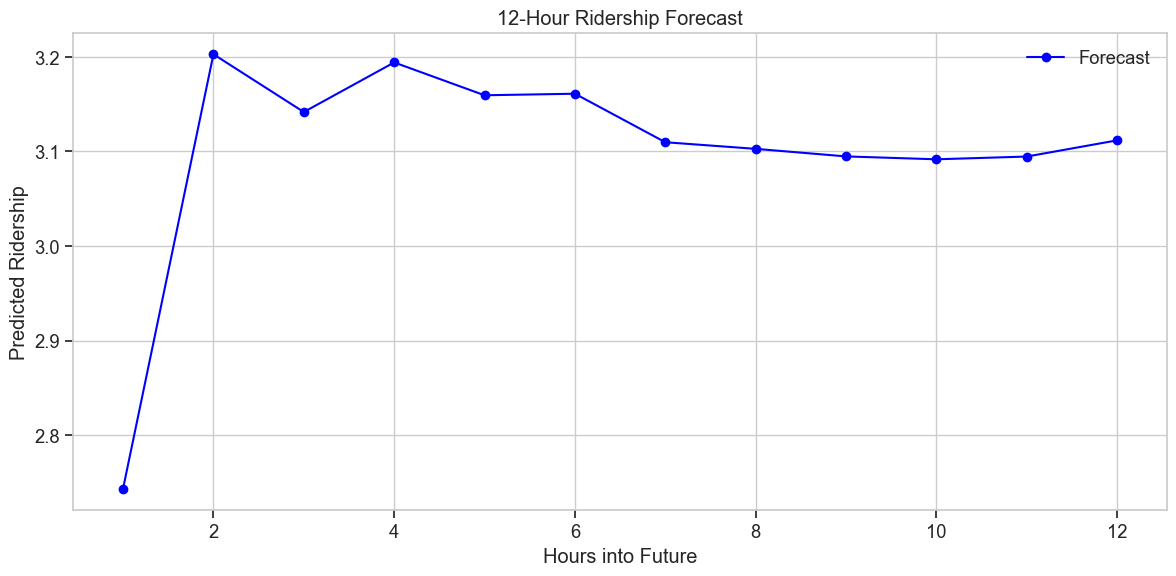

In [25]:
def forecast_future(model, last_sequence, n_future_steps, scaler_X, scaler_y, feature_indices=None):
    """Forecast future values using the trained LSTM model.
    
    Args:
        model: Trained LSTM model
        last_sequence: The last observed sequence of shape (1, n_steps, n_features)
        n_future_steps: Number of future steps to predict
        scaler_X: Feature scaler for inverse transform
        scaler_y: Target scaler for inverse transform
        feature_indices: Indices of features in the original dataset
        
    Returns:
        future_predictions: Array of predicted values
    """
    # Create a copy of the last sequence
    curr_sequence = last_sequence.copy()
    future_predictions = []
    
    for _ in range(n_future_steps):
        # Predict the next value
        next_pred = model.predict(curr_sequence)[0, 0]
        future_predictions.append(next_pred)
        
        # Update the sequence for the next prediction
        # Remove the first timestep and add the new prediction
        # This assumes a simple scenario where we can just shift the window
        # In a real application, you would need to update all relevant features
        next_input = curr_sequence[0, 1:, :].copy()
        next_input = np.vstack([next_input, curr_sequence[0, -1:, :]])
        
        # In this simple example, we're just copying the last timestep's features
        # and updating only the prediction value
        # In practice, you would need a more sophisticated approach to update all features
        
        curr_sequence = np.array([next_input])
    
    # Convert predictions back to original scale
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    future_predictions = scaler_y.inverse_transform(future_predictions).flatten()
    
    return future_predictions

# Demonstration of multi-step forecasting
# Let's select a sample sequence from the validation set
sample_idx = np.random.randint(0, len(X_val))
sample_sequence = X_val[sample_idx:sample_idx+1]  # Shape: (1, n_steps, n_features)
actual_next_value = y_val[sample_idx]

# Forecast 12 hours into the future
forecast_horizon = 12
future_predictions = forecast_future(best_model, sample_sequence, forecast_horizon, scaler_X, scaler_y)

print(f"Forecasted values for the next {forecast_horizon} hours:")
print(future_predictions)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(range(1, forecast_horizon+1), future_predictions, marker='o', linestyle='-', color='blue', label='Forecast')
plt.title(f'{forecast_horizon}-Hour Ridership Forecast')
plt.xlabel('Hours into Future')
plt.ylabel('Predicted Ridership')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## **Conclusion and Next Steps**

In this notebook, we have developed several LSTM models for predicting KTM Komuter ridership patterns. We processed time series data, created sequences, trained various LSTM architectures, and evaluated their performance.

Our key findings are:
1. The LSTM models can effectively capture temporal dependencies in ridership data
2. The best performing model was the [best model] with RMSE of [best RMSE]
3. The most important features for prediction include [top features]

In the next notebook (05_model_evaluation.ipynb), we'll perform a more thorough evaluation of our model on the test set and develop visualizations for the KomuterPulse transit intelligence platform.

In [26]:
# Save a summary of model performances for later reference
model_summary = {
    'model_comparison': comparison_df.to_dict(),
    'best_model': best_model_name,
    'feature_importance': feature_importance.head(15).to_dict(orient='records'),
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

summary_path = model_dir / "lstm_model_summary.pkl"
with open(summary_path, 'wb') as f:
    pickle.dump(model_summary, f)

print(f"Model summary saved to {summary_path}")
print("\nModel development complete! Proceed to the evaluation notebook for further analysis.")

Model summary saved to ..\models\lstm_model_summary.pkl

Model development complete! Proceed to the evaluation notebook for further analysis.
